### Experimental Parameters

In [15]:
params = {'Block proposal rate parameter': 'variable',
 'Block size (txs)': 50,
 'Duration (sec)': 1200,
 'Fork choice rule': 'longest-chain',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 100,
 'Probability of error in transaction confirmation': 0.1,
 'Transaction dataset': 'poisson'}

## Main Chain Arrival Latency

|Proposal Rate|Trial 1|Trial 2|Trial 3|Trial 4|Trial 5|
|-------------|-------|-------|-------|-------|-------|
|0.1|476.6873909201745|511.3261950108599|586.4655491424162|530.5368359794612|489.36216946428783|
|0.2|549.0298618823134|608.2857895384811|559.3056771363388|548.0272004106491|538.3845417387648|
|0.3|510.1755447375935|634.2211314717139|459.4147580163504|520.9733980406907|628.7088189257806|
|0.4|512.698308772176|535.2060506783882|618.7489388412548|565.0990734159146|552.8482421051343|
|0.5|618.5266714377806|561.499847075668|582.2165470759318|566.6519693138375|564.8026810733396|

## Finalization Latency

|Proposal Rate|Trial 1|Trial 2|Trial 3|Trial 4|Trial 5|
|-------------|-------|-------|-------|-------|-------|
|0.1|569.57936098319|589.271907163032|354.1065290127063|367.77140065500754|525.6713096438087|
|0.2|468.4925534306116|363.4581350687132|361.790337044683|449.4856717878158|434.0697373418087|
|0.3|478.06683807761067|326.34183587643685|546.9946049420713|461.8992043828455|315.94211311111724|
|0.4|447.6095581737059|446.3682905926886|358.68881187126834| 398.2092505051823|423.6258479182726|
|0.5|364.5459073102|381.3272181432961|386.8943276589553|378.19267107715297|423.45493701661616|

In [16]:
main_chain_arrival_latencies = {0.1: [476.6873909201745, 511.3261950108599, 586.4655491424162, 530.5368359794612,489.36216946428783],
                                0.2: [549.0298618823134, 608.2857895384811, 559.3056771363388, 548.0272004106491, 538.3845417387648],
                                0.3: [510.1755447375935, 634.2211314717139, 459.4147580163504, 520.9733980406907, 628.7088189257806],
                                0.4: [512.698308772176, 535.2060506783882, 618.7489388412548, 565.0990734159146, 552.8482421051343],
                                0.5: [618.5266714377806, 561.499847075668, 582.2165470759318, 566.6519693138375, 564.8026810733396]}
finalization_latencies = {0.1: [569.57936098319, 589.271907163032, 354.1065290127063, 367.77140065500754, 525.6713096438087],
                          0.2: [468.4925534306116, 363.4581350687132, 361.790337044683, 449.4856717878158, 434.0697373418087],
                          0.3: [478.06683807761067, 326.34183587643685, 546.9946049420713, 461.8992043828455, 315.94211311111724],
                          0.4: [447.6095581737059, 446.3682905926886, 358.68881187126834, 398.2092505051823, 423.6258479182726],
                          0.5: [364.5459073102, 381.3272181432961, 386.8943276589553, 378.19267107715297, 423.45493701661616]}
avg_main_chain_latencies = {}
for rate in main_chain_arrival_latencies:
    avg_main_chain_latencies[rate] = sum(main_chain_arrival_latencies[rate])/len(main_chain_arrival_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)
avg_finalization_latencies = {}
for rate in finalization_latencies:
    avg_finalization_latencies[rate] = sum(finalization_latencies[rate])/len(finalization_latencies[rate])
    
print("Average Finalization Latency:", avg_finalization_latencies)


Average Main Chain Arrival Latency: {0.1: 518.87562810344, 0.2: 560.6066141413094, 0.3: 550.6987302384258, 0.4: 556.9201227625737, 0.5: 578.7395431953115}
Average Finalization Latency: {0.1: 481.28010149154886, 0.2: 415.45928693472644, 0.3: 425.84891927801635, 0.4: 414.90035181222356, 0.5: 386.8830122412441}


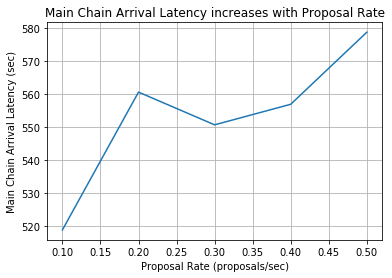

In [18]:
import matplotlib.pylab as plt

x = avg_main_chain_latencies.keys()
y1 = avg_main_chain_latencies.values()
y2 = avg_finalization_latencies.values()

plt.xlabel('Proposal Rate (proposals/sec)')
plt.ylabel('Main Chain Arrival Latency (sec)')
plt.title('Main Chain Arrival Latency increases with Proposal Rate')
plt.grid(True)

plt.plot(x, y1)
plt.show()

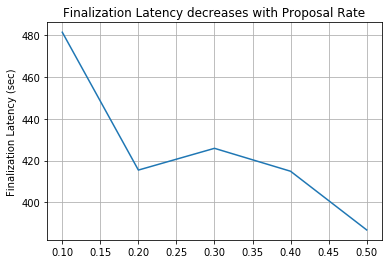

In [19]:
plt.title('Finalization Latency decreases with Proposal Rate')
plt.ylabel('Finalization Latency (sec)')
plt.grid(True)

plt.plot(x, y2)
plt.show()